In [1]:
import json
import gcsfs

with open('pangeo-181919-e7bc5bdaf4d5.json') as f:
    token = json.load(f)
gcs = gcsfs.GCSFileSystem(token=token)

In [2]:
from dask_gateway import GatewayCluster, Gateway
from distributed import Client
g = Gateway()
g.list_clusters()

[]

In [3]:
#cluster = g.connect(g.list_clusters()[0].name)

In [4]:
options = g.cluster_options()
options.worker_cores = 2; options.worker_memory = 4
# Create a cluster with those options
cluster = g.new_cluster(options)

In [5]:
g.list_clusters()

[ClusterReport<name=prod.8dadd183606e4c6e890d7dde4fd0f9fa, status=RUNNING>]

In [6]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.8dadd183606e4c6e890d7dde4fd0f9fa/status,


In [7]:
cluster.scale(40)

### Define functions and start timing

In [8]:
import zarr, numpy as np, dask

def load():
    mapper = gcs.get_mapper(gcs.ls('pangeo-argo-eke/global/mean_and_anomalies/with_pressure_coordinate/readable_ws_and_NHarm/scattered_data_in_betaparamcomputation')[5])
    z = zarr.open_consolidated(mapper)
    data, lat, lon, time = z.Anomalies[:][:,0],z.latitude[:],z.longitude[:],z.time[:]    
    return data, lat, lon, time

@dask.delayed
def function_load():
    data, lat, lon, time = load()
    ### Do computation with lat, lon, data, time    
    return None

@dask.delayed
def function_scattered(data_scattered, lat_scattered, lon_scattered, time_scattered):
    data, lat, lon, time = data_scattered, lat_scattered, lon_scattered, time_scattered
    ### Do computation with lat, lon, data, time
    return None

data, lat, lon, time = load()

### The loaded data are numpy arrays of equal size stored as zarr (by first creating xarray dataset)

In [9]:
print([arr.dtype for arr in (data, lat,lon, time)])

[dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64')]


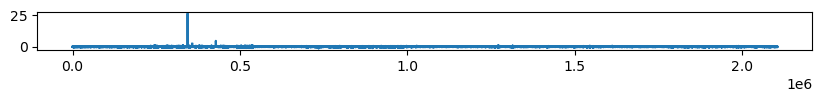

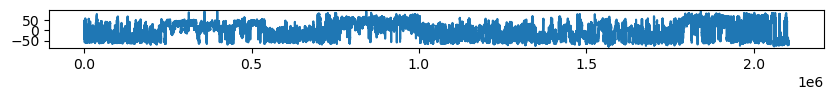

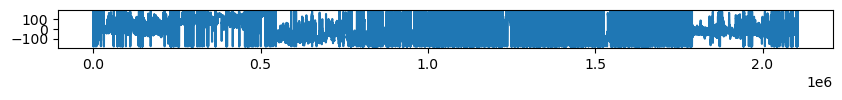

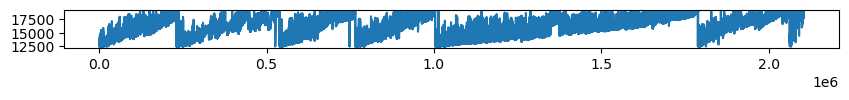

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,0.5));plt.plot(data);plt.show();
plt.figure(figsize=(10,0.5));plt.plot(lat);plt.show()
plt.figure(figsize=(10,0.5));plt.plot(lon);plt.show()
plt.figure(figsize=(10,0.5));plt.plot(time);plt.show()

Scatter data beforehand:

In [13]:
data_scat,lat_scat,lon_scat,time_scat = client.scatter(data),client.scatter(lat),client.scatter(lon),client.scatter(time)

In [14]:
client.who_has()

Key,Copies,Workers
ndarray-6d237d7cdc3ba10469a945ee0aa0097f,1,tls://10.8.5.4:44793
ndarray-7ae0dceb1250d81d27e358cbc499962e,1,tls://10.8.5.4:44793
ndarray-a0de17639c98fe9b5b41d3c6886d76fe,1,tls://10.8.6.3:37893
ndarray-46f31d62d0649b9a2c98ac1e49d9a144,1,tls://10.8.6.5:34287


Scatter data with 'broadcast=True' :

In [15]:
data_bcast, lat_bcast, lon_bcast, time_bcast = client.scatter(data, broadcast=True), client.scatter(lat, broadcast=True), client.scatter(lon, broadcast=True), client.scatter(time, broadcast=True)

In [16]:
client.who_has()

Key,Copies,Workers
ndarray-6d237d7cdc3ba10469a945ee0aa0097f,1,tls://10.8.7.5:35141
ndarray-7ae0dceb1250d81d27e358cbc499962e,1,tls://10.8.12.5:45141
ndarray-a0de17639c98fe9b5b41d3c6886d76fe,1,tls://10.8.7.3:34321
ndarray-46f31d62d0649b9a2c98ac1e49d9a144,1,tls://10.8.6.5:34287


In [59]:
cluster.scale(0)

In [60]:
cluster.close()

In [61]:
cluster.shutdown()

In [65]:
client.close()

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 1389, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLZeroReturnError: TLS/SSL connection has been closed (EOF) (_ssl.c:997)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 206, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 698, in _handle_events
    self._handle_read()
  File "/srv/conda/envs/notebook/lib/